In [1]:
import sys
sys.path.append('gym-unbalanced-disk/gym_unbalanced_disk/')
from torch import nn
import torch, gym, gym_unbalanced_disk, time, gym.wrappers
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
import os
import datetime

In [2]:
class QfunctionTanh(nn.Module):
    def __init__(self, env):
        super(QfunctionTanh,self).__init__()
        self.lay1 = nn.Linear(env.observation_space.shape[0], 40)
        self.F1 =  nn.Tanh()
        self.lay2 = nn.Linear(40,env.action_space.n)
    
    def forward(self, obs):
        return self.lay2(self.F1(self.lay1(obs)))

In [3]:
class QfunctionReLU(nn.Module):
    def __init__(self, env):
        super(QfunctionReLU,self).__init__()
        self.lay1 = nn.Linear(env.observation_space.shape[0], 40)
        self.F1 =  nn.ReLU()
        self.lay2 = nn.Linear(40,env.action_space.n)
    
    def forward(self, obs):
        return self.lay2(self.F1(self.lay1(obs)))

In [4]:
class QfunctionMoreLayers(nn.Module):
    def __init__(self, env):
        super(QfunctionMoreLayers, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 20),
            nn.Tanh(),
            nn.Linear(20, 80),
            nn.Tanh(),
            nn.Linear(80, 40),
            nn.Tanh(),
            nn.Linear(40, env.action_space.n)
        )
    
    def forward(self, obs):
        return self.layers(obs)

In [5]:
class QfunctionMoreLayersReLU(nn.Module):
    def __init__(self, env):
        super(QfunctionMoreLayersReLU,self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, env.action_space.n)
        )
    
    def forward(self, obs):
        return self.layers(obs)

In [6]:
class QfunctionLessNodes(nn.Module):
    def __init__(self, env):
        super(QfunctionLessNodes,self).__init__()
        self.lay1 = nn.Linear(env.observation_space.shape[0], 15)
        self.F1 =  nn.Tanh() 
        self.lay2 = nn.Linear(15,env.action_space.n)
    
    def forward(self, obs):
        return self.lay2(self.F1(self.lay1(obs)))

In [7]:
class QfunctionMoreNodes(nn.Module):
    def __init__(self, env):
        super(QfunctionMoreNodes,self).__init__()
        self.lay1 = nn.Linear(env.observation_space.shape[0], 100)
        self.F1 =  nn.Tanh()
        self.lay2 = nn.Linear(100,env.action_space.n)
    
    def forward(self, obs):
        return self.lay2(self.F1(self.lay1(obs)))

In [8]:
Qfun_classes = [QfunctionTanh, QfunctionReLU, QfunctionMoreLayers, QfunctionMoreLayersReLU, QfunctionLessNodes, QfunctionMoreNodes]

In [9]:
def show(Q,env):
    u = []
    theta = []
    omega = []
    with torch.no_grad():
        #you can use Qfun(obs) as a shorthand for the q function.
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() #convert x to torch.tensor -> put in the Q function -> back to numpy
        try:
            obs = env.reset() #b)
            env.render() #b)
            time.sleep(10) # give time to open window
            while True: #b)
                action = np.argmax(Qfun(obs)) #b)
                obs, reward, done, info = env.step(action) #b)
                time.sleep(1/60) #b)
                env.render() #b)
                u.append(env.u)
                theta.append(env.th)
                omega.append(env.omega)
                if done: #b)
                    time.sleep(0.5)  #b)
                    break  #b)
        finally: #this will always run even when an error occurs
            env.close()
            return u,theta,omega

In [10]:
def rollout(Q, env, epsilon=0.1, N_rollout=10_000): 
    #save the following (use .append)
    Start_state = [] #hold an array of (x_t)
    Actions = [] #hold an array of (u_t)
    Rewards = [] #hold an array of (r_{t+1})
    End_state = [] #hold an array of (x_{t+1})
    Terminal = [] #hold an array of (terminal_{t+1})
    # Qfun( a numpy array of the obs) -> a numpy array of Q values
    Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() 
    with torch.no_grad():
        
        obs = env.reset() #c)
        for i in range(N_rollout): #c)
            if np.random.uniform()>epsilon: #c)
                Qnow = Qfun(obs) #c)
                action = np.argmax(Qnow) #c)
            else: #c)
                action = env.action_space.sample() #c)
            Start_state.append(obs) #c)
            Actions.append(action) #c)

            obs_next, reward, done, info = env.step(action) #c)
            terminal = done and not info.get('TimeLimit.truncated', False) #c)

            Terminal.append(terminal) #c)
            Rewards.append(reward) #c)
            End_state.append(obs_next) #c)

            if done: #c)
                obs = env.reset() #c)
            else: #c)
                obs = obs_next #c)
                
    #error checking:
    assert len(Start_state)==len(Actions)==len(Rewards)==len(End_state)==len(Terminal), f'error in lengths: {len(Start_state)}=={len(Actions)}=={len(Rewards)}=={len(End_state)}=={len(Dones)}'
    return np.array(Start_state), np.array(Actions), np.array(Rewards), np.array(End_state), np.array(Terminal).astype(int)

In [11]:
def eval_Q(Q,env):
    with torch.no_grad():
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
        rewards_acc = 0 #d)
        obs = env.reset() #d)
        while True: #d)
            action = np.argmax(Qfun(obs)) #d)
            obs, reward, done, info = env.step(action) #d)
            rewards_acc += reward #d)
            if done: #d)
                return rewards_acc #d)

In [12]:
def DQN_rollout(Q, optimizer, env, gamma=0.98, use_target_net=False, N_iterations=21, N_rollout=20000, \
                N_epochs=10, batch_size=32, N_evals=10, target_net_update_feq=100):
    best = -float('inf')
    torch.save(Q.state_dict(),'Q-checkpoint')
    try:
        for iteration in range(N_iterations):
            epsilon = 1.0 - iteration/(N_iterations-1) #e=) 1.
            print(f'rollout iteration {iteration} with epsilon={epsilon:.2%}...')
            
            #2. rollout
            Start_state, Actions, Rewards, End_state, Dones = rollout(Q, env, epsilon=epsilon, N_rollout=N_rollout) #e) 2.
            
            #Data conversion, no changes required
            convert = lambda x: [torch.tensor(xi,dtype=torch.float32) for xi in x]
            Start_state, Rewards, End_state, Dones = convert([Start_state, Rewards, End_state, Dones])
            Actions = Actions.astype(int)

            print('starting training on rollout information...')
            t = 0
            for epoch in range(N_epochs): 
                for i in range(batch_size,len(Start_state)+1,batch_size): 
                    if t%target_net_update_feq==0:
                        Qtarget = deepcopy(Q) #g)
                        pass
                    t += 1
                    
                    Start_state_batch, Actions_batch, Rewards_batch, End_state_batch, Dones_batch = [d[i-batch_size:i] for d in [Start_state, Actions, Rewards, End_state, Dones]] #e=) 3.
                    
                    with torch.no_grad(): #3.
                        if use_target_net:
                            maxQ = torch.max(Qtarget(End_state_batch),dim=1)[0] #g)
                        else:
                            maxQ = torch.max(Q(End_state_batch),dim=1)[0] #e=) 3.
                    
                    action_index = np.stack((np.arange(batch_size),Actions_batch),axis=0)
                    Qnow = Q(Start_state_batch)[action_index] #Q(x_t,u_t) is given
                    
                    Loss = torch.mean((Rewards_batch + gamma*maxQ*(1-Dones_batch) - Qnow)**2) #e) 3.
                    optimizer.zero_grad() #e) 3.
                    Loss.backward() #e) 3.
                    optimizer.step() #e) 3.
                
                score = np.mean([eval_Q(Q,env) for i in range(N_evals)]) #e=) 3.
                
                print(f'iteration={iteration} epoch={epoch} Average Reward per episode:',score)
                if score>best:
                    best = score
                    print('################################# \n new best',best,'saving Q... \n#################################')
                    torch.save(Q.state_dict(),'Q-checkpoint')
            
            print('loading best result')
            Q.load_state_dict(torch.load('Q-checkpoint'))
    finally: #this will always run even when using the a KeyBoard Interrupt. 
        print('loading best result')
        Q.load_state_dict(torch.load('Q-checkpoint'))

In [13]:
target_angle = np.pi # target set to be balanced on top

In [14]:
angle_reward = lambda self: ((np.cos(self.th-target_angle)+1.5)**2 - 0.25)
correctVelocity_reward = lambda self: 0.00250*(((np.cos(self.th)+1)/2)*(self.omega)**2)
voltage_penalty = lambda self: -0.005*((self.u)**2)
incorrectAngle_penalty = lambda self: -0.05*np.abs(self.th-target_angle)

reward_function = lambda self: angle_reward(self) + correctVelocity_reward(self) + voltage_penalty(self) + incorrectAngle_penalty(self)

max_episode_steps = 250
gamma = 0.98
batch_size = 32
N_iterations = 15
N_rollout = 10000
N_epochs = 5
N_evals = 5
lr = 0.0005

In [15]:
env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=3.)
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)
env.change_reward_function(reward_function)

Running from folder


In [16]:
env.set_discrete_values(discrete_size = 5, minmax = 3.0, div = 3/0.9, rnd = 2)
# env.set_discrete_values(discrete_size = 9, minmax = 3.0, div = 2.5, rnd = 2)
# env.set_discrete_values_manual([-3.0, -1.5, -0.75, -0.5, -0.25, -0.15, -0.1, 0, 0.1, 0.15, 0.25, 0.5, 0.75, 1.5, 3.0])

Discrete value set changed to [-3.0, -0.9, 0, 0.9, 3.0]


rollout iteration 0 with epsilon=100.00%...
starting training on rollout information...
iteration=0 epoch=0 Average Reward per episode: 220.47908905754207
################################# 
 new best 220.47908905754207 saving Q... 
#################################
iteration=0 epoch=1 Average Reward per episode: -36.7797633471135
iteration=0 epoch=2 Average Reward per episode: 37.705671806695335
iteration=0 epoch=3 Average Reward per episode: 27.281424905120172
iteration=0 epoch=4 Average Reward per episode: 27.307026244155214
loading best result
rollout iteration 1 with epsilon=92.86%...
starting training on rollout information...
iteration=1 epoch=0 Average Reward per episode: 215.25169648999113
iteration=1 epoch=1 Average Reward per episode: 593.0891378521319
################################# 
 new best 593.0891378521319 saving Q... 
#################################
iteration=1 epoch=2 Average Reward per episode: 46.09776432350965
iteration=1 epoch=3 Average Reward per episode: 44.

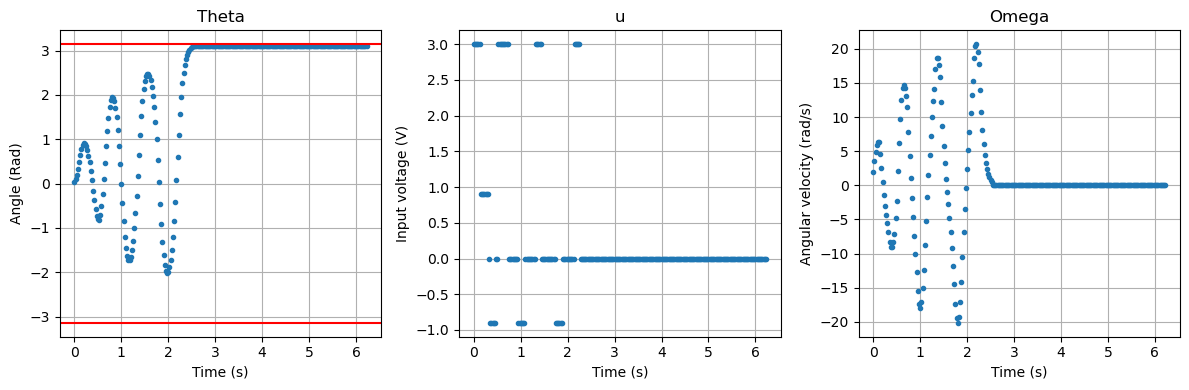

rollout iteration 0 with epsilon=100.00%...
starting training on rollout information...
iteration=0 epoch=0 Average Reward per episode: -24.617256009767384
################################# 
 new best -24.617256009767384 saving Q... 
#################################
iteration=0 epoch=1 Average Reward per episode: -105.77427751226723
iteration=0 epoch=2 Average Reward per episode: -202.85326383932102
iteration=0 epoch=3 Average Reward per episode: -197.56264666458418
iteration=0 epoch=4 Average Reward per episode: -197.58712899036772
loading best result
rollout iteration 1 with epsilon=92.86%...
starting training on rollout information...
iteration=1 epoch=0 Average Reward per episode: -131.85081074104787
iteration=1 epoch=1 Average Reward per episode: -134.09993812851786
iteration=1 epoch=2 Average Reward per episode: -202.8193544869835
iteration=1 epoch=3 Average Reward per episode: -33.437527781594596
iteration=1 epoch=4 Average Reward per episode: -76.05303372263506
loading best re

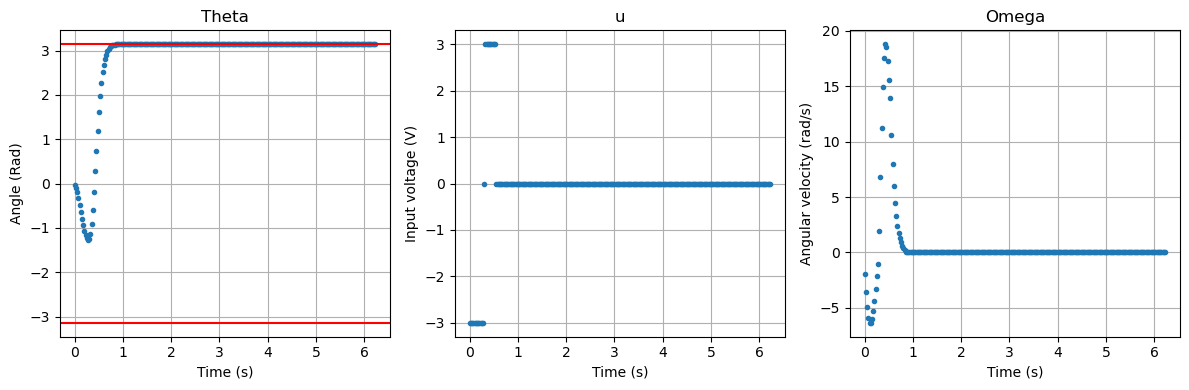

rollout iteration 0 with epsilon=100.00%...
starting training on rollout information...
iteration=0 epoch=0 Average Reward per episode: -4.744987877635376
################################# 
 new best -4.744987877635376 saving Q... 
#################################
iteration=0 epoch=1 Average Reward per episode: -12.897504571343987
iteration=0 epoch=2 Average Reward per episode: 174.21161549920276
################################# 
 new best 174.21161549920276 saving Q... 
#################################
iteration=0 epoch=3 Average Reward per episode: 328.39959726074187
################################# 
 new best 328.39959726074187 saving Q... 
#################################
iteration=0 epoch=4 Average Reward per episode: -204.48353687234712
loading best result
rollout iteration 1 with epsilon=92.86%...
starting training on rollout information...
iteration=1 epoch=0 Average Reward per episode: -201.38821038325676
iteration=1 epoch=1 Average Reward per episode: -99.93647252092663


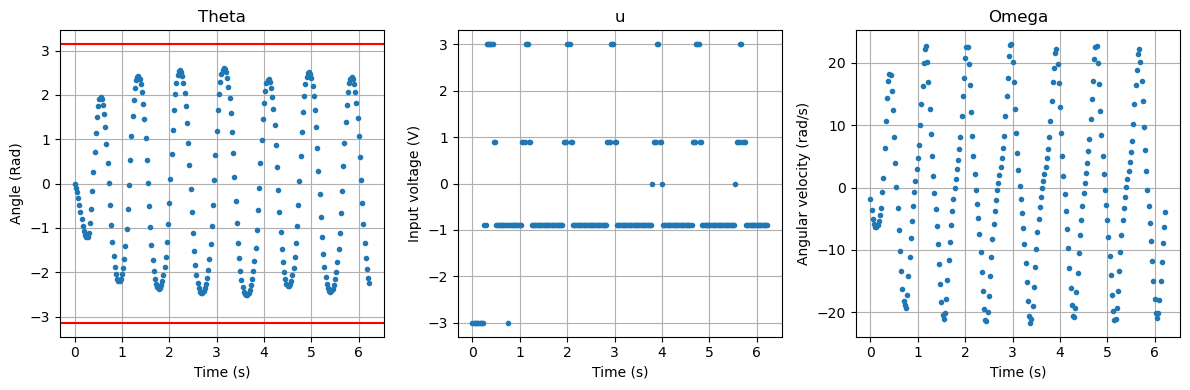

rollout iteration 0 with epsilon=100.00%...
starting training on rollout information...
iteration=0 epoch=0 Average Reward per episode: -119.32654488307159
################################# 
 new best -119.32654488307159 saving Q... 
#################################
iteration=0 epoch=1 Average Reward per episode: -192.64932545194785
iteration=0 epoch=2 Average Reward per episode: -198.19338280008674
iteration=0 epoch=3 Average Reward per episode: 565.9813676539919
################################# 
 new best 565.9813676539919 saving Q... 
#################################
iteration=0 epoch=4 Average Reward per episode: 59.81412538931985
loading best result
rollout iteration 1 with epsilon=92.86%...
starting training on rollout information...
iteration=1 epoch=0 Average Reward per episode: -54.55220433718355
iteration=1 epoch=1 Average Reward per episode: -112.70113966601143
iteration=1 epoch=2 Average Reward per episode: -86.3794143979591
iteration=1 epoch=3 Average Reward per episode

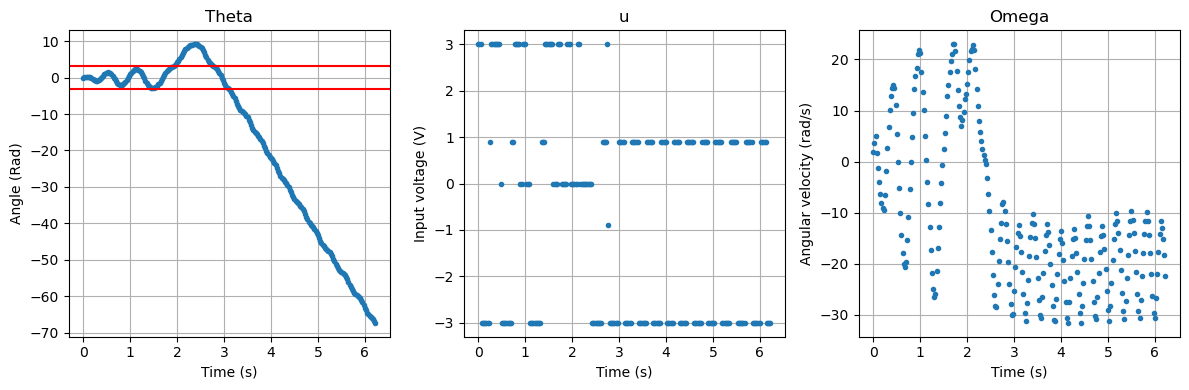

rollout iteration 0 with epsilon=100.00%...
starting training on rollout information...
iteration=0 epoch=0 Average Reward per episode: 51.98987017233151
################################# 
 new best 51.98987017233151 saving Q... 
#################################
iteration=0 epoch=1 Average Reward per episode: 104.5383623412647
################################# 
 new best 104.5383623412647 saving Q... 
#################################
iteration=0 epoch=2 Average Reward per episode: 266.45988294327753
################################# 
 new best 266.45988294327753 saving Q... 
#################################
iteration=0 epoch=3 Average Reward per episode: 685.0308320798525
################################# 
 new best 685.0308320798525 saving Q... 
#################################
iteration=0 epoch=4 Average Reward per episode: 406.07406626155426
loading best result
rollout iteration 1 with epsilon=92.86%...
starting training on rollout information...
iteration=1 epoch=0 Average Rewa

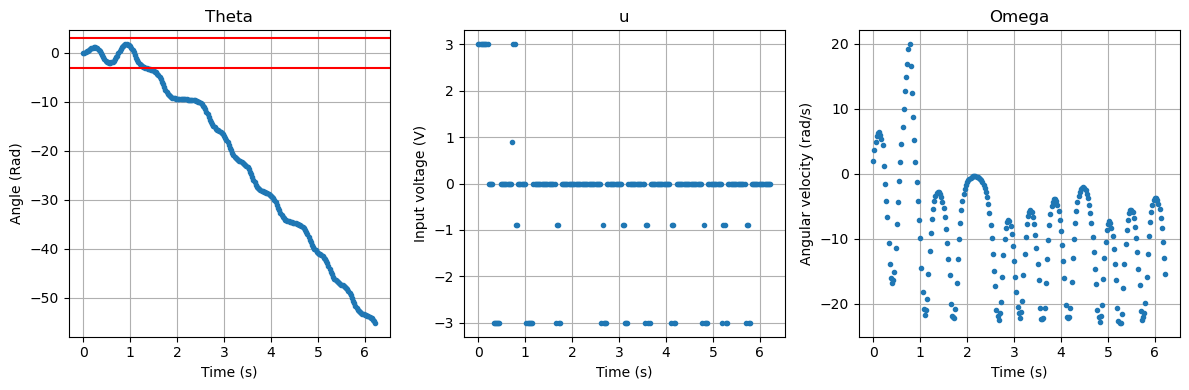

rollout iteration 0 with epsilon=100.00%...
starting training on rollout information...
iteration=0 epoch=0 Average Reward per episode: 87.42765857599791
################################# 
 new best 87.42765857599791 saving Q... 
#################################
iteration=0 epoch=1 Average Reward per episode: 131.70479745872092
################################# 
 new best 131.70479745872092 saving Q... 
#################################
iteration=0 epoch=2 Average Reward per episode: -7.636120144175448
iteration=0 epoch=3 Average Reward per episode: 263.1091842041066
################################# 
 new best 263.1091842041066 saving Q... 
#################################
iteration=0 epoch=4 Average Reward per episode: 212.0912862160745
loading best result
rollout iteration 1 with epsilon=92.86%...
starting training on rollout information...
iteration=1 epoch=0 Average Reward per episode: -145.88968435068665
iteration=1 epoch=1 Average Reward per episode: -126.57549141839402
iterat

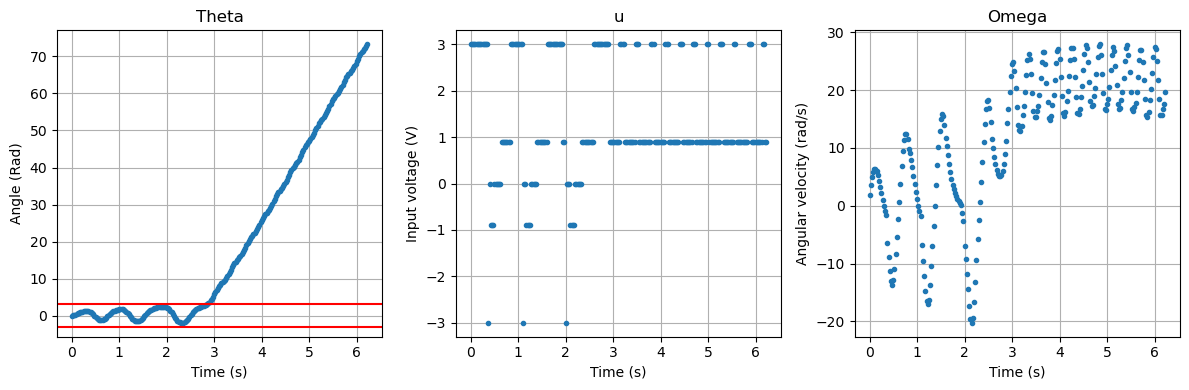

In [17]:
u_list = []  # List to store u for each run
theta_list = []  # List to store theta for each run
omega_list = []  # List to store omega for each run

for i in range(len(Qfun_classes)):
    assert isinstance(env.action_space,gym.spaces.Discrete), 'action space requires to be discrete'

    Q = Qfun_classes[i](env)
    
    optimizer = torch.optim.Adam(Q.parameters(),lr=lr) #low learning rate
    DQN_rollout(Q, optimizer, env, use_target_net=True, gamma=gamma, N_iterations=N_iterations, \
                N_rollout=N_rollout, N_epochs=N_epochs, N_evals=N_evals)
    u,theta,omega = show(Q,env)

    # Save Q to a file
    torch.save(Q.state_dict(), 'Qfunction' + str(Q.__class__.__name__) + '.pt')

    # Saving u, theta, omega
    u_list.append(u)  # Append u to the list
    theta_list.append(theta)  # Append theta to the list
    omega_list.append(omega)  # Append omega to the list

    target_angle = np.pi # target set to be balanced on top

    # Create a figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Plot theta
    axs[0].plot([i*env.dt for i in range(max_episode_steps)], theta, '.')
    axs[0].set_title('Theta')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Angle (Rad)')
    axs[0].axhline(y=target_angle, color='r', linestyle='-')
    axs[0].axhline(y=-target_angle, color='r', linestyle='-')
    axs[0].grid(True)

    # Plot u
    axs[1].plot([i*env.dt for i in range(max_episode_steps)], u, '.')
    axs[1].set_title('u')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Input voltage (V)')
    axs[1].grid(True)

    # Plot omega
    axs[2].plot([i*env.dt for i in range(max_episode_steps)], omega, '.')
    axs[2].set_title('Omega')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Angular velocity (rad/s)')
    axs[2].grid(True)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    eval_Q(Q,env)

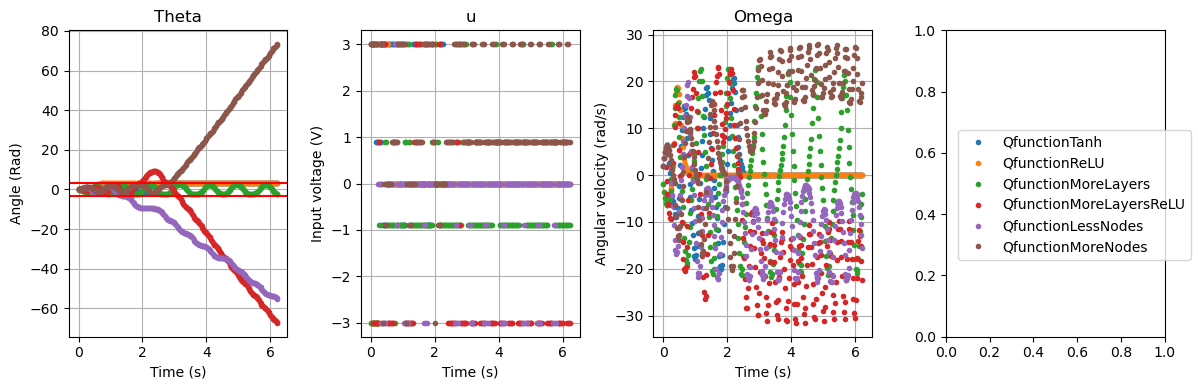

In [18]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 4, figsize=(12, 4))

# Plot theta for each run
for theta in theta_list:
    axs[0].plot([i*env.dt for i in range(max_episode_steps)], theta, '.')

axs[0].set_title('Theta')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Angle (Rad)')
axs[0].axhline(y=target_angle, color='r', linestyle='-')
axs[0].axhline(y=-target_angle, color='r', linestyle='-')
axs[0].grid(True)

# Plot u for each run
for u in u_list:
    axs[1].plot([i*env.dt for i in range(max_episode_steps)], u, '.')

axs[1].set_title('u')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Input voltage (V)')
axs[1].grid(True)

# Plot omega for each run
for omega in omega_list:
    axs[2].plot([i*env.dt for i in range(max_episode_steps)], omega, '.')

axs[2].set_title('Omega')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Angular velocity (rad/s)')
axs[2].grid(True)

# Get the class names from Qfun_classes
class_names = [qfun(env).__class__.__name__ for qfun in Qfun_classes]

# Add a single legend on the right side outside the figures
fig.legend(class_names, loc='center right')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
